In [83]:
!pip install torchinfo

### Import Libraries

In [84]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

### Configuration

In [85]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [86]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [87]:
data_dir = "/kaggle/input/fruit-condition/Fruits Original"

file_paths = []
labels = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

for fruit in os.listdir(data_dir):
    fruit_dir = os.path.join(data_dir, fruit)
    if not os.path.isdir(fruit_dir):
        continue
    for condition in os.listdir(fruit_dir):
        condition_dir = os.path.join(fruit_dir, condition)
        if not os.path.isdir(condition_dir):
            continue
        for file_name in os.listdir(condition_dir):
            if file_name.lower().endswith(valid_extensions):
                file_path = os.path.join(condition_dir, file_name)
                if os.path.isfile(file_path):
                    file_paths.append(file_path)
                    labels.append(f"{fruit}_{condition}")

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,file_path,label
0,/kaggle/input/fruit-condition/Fruits Original/...,Apple_Rotten
1,/kaggle/input/fruit-condition/Fruits Original/...,Apple_Formalin-mixed
2,/kaggle/input/fruit-condition/Fruits Original/...,Mango_Fresh
3,/kaggle/input/fruit-condition/Fruits Original/...,Mango_Fresh
4,/kaggle/input/fruit-condition/Fruits Original/...,Orange_Fresh


Class: Grape_Fresh, Count: 770
Class: Apple_Fresh, Count: 765
Class: Mango_Fresh, Count: 763
Class: Orange_Fresh, Count: 753
Class: Banana_Fresh, Count: 749
Class: Banana_Formalin-mixed, Count: 660
Class: Orange_Rotten, Count: 656
Class: Orange_Formalin-mixed, Count: 647
Class: Apple_Formalin-mixed, Count: 643
Class: Banana_Rotten, Count: 632
Class: Apple_Rotten, Count: 630
Class: Grape_Rotten, Count: 630
Class: Mango_Rotten, Count: 630
Class: Mango_Formalin-mixed, Count: 616
Class: Grape_Formalin-mixed, Count: 610


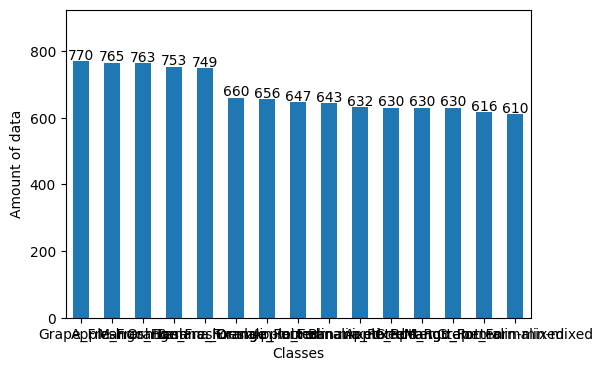

In [88]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

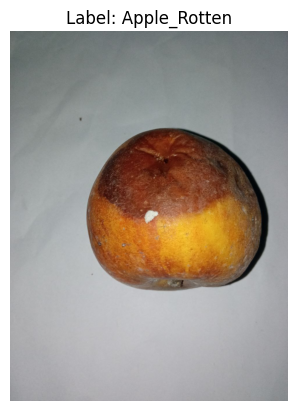

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [90]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [91]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  7107
Validation Data:  1523
Test Data:  1524
-------------------------------------------
Total amounts of data in the dataset:  10154


In [92]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                    Count
---------------------  -------
Grape_Fresh                539
Apple_Fresh                536
Mango_Fresh                534
Orange_Fresh               527
Banana_Fresh               524
Banana_Formalin-mixed      462
Orange_Rotten              459
Orange_Formalin-mixed      453
Apple_Formalin-mixed       450
Banana_Rotten              442
Apple_Rotten               441
Grape_Rotten               441
Mango_Rotten               441
Mango_Formalin-mixed       431
Grape_Formalin-mixed       427

Validation Dataset
Class                    Count
---------------------  -------
Grape_Fresh                115
Apple_Fresh                114
Mango_Fresh                114
Orange_Fresh               113
Banana_Fresh               112
Banana_Formalin-mixed       99
Orange_Rotten               98
Orange_Formalin-mixed       97
Apple_Formalin-mixed        96
Mango_Rotten                95
Banana_Rotten               95
Grape_Rotten                95
Apple

### Device Variable

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Checkpoint

In [94]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# Data Transfer

In [95]:
# Build the label map from your combined labels (e.g. Apple_Fresh, etc.)
unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
total_class = len(label_map)  # <- pass this to model.fc

### Dataset Class, Dataloader and Transform

In [96]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, label_map, is_lb=True):
        self.dataframe = dataframe
        self.normalize = normalize
        self.label_map = label_map  
        self.is_lb = is_lb

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path).convert('RGB')  

        if self.is_lb:
            label_str = self.dataframe.iloc[index]['label']
            label = self.label_map[label_str]  
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [97]:
train_batch = 32
val_batch = 8

def data_transform(label_map):
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(
        dataframe=train_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        dataframe=valid_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    test_dataset = ImageDataset(
        dataframe=test_df,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

In [98]:
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform(label_map)

### Neural Network (EfficientNet)

In [99]:
import torch
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_class = 15  # you had 10 before, but your dataset has 15 classes
learning_rate = 0.0001

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Change final layer for your number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))  # batch size excluded


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 175MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### Training

In [100]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 223/223 [01:35<00:00,  2.35it/s, acc=0.765, loss=0.871]

Training Loss: 0.871 Acc: 0.765


Validation Loss: 0.238 Acc: 0.903
Best model saved at epoch 1 with validation accuracy: 0.903


Epoch 2/20: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s, acc=0.93, loss=0.212] 

Training Loss: 0.212 Acc: 0.930


Validation Loss: 0.084 Acc: 0.973
Best model saved at epoch 2 with validation accuracy: 0.973


Epoch 3/20: 100%|██████████| 223/223 [01:25<00:00,  2.62it/s, acc=0.968, loss=0.108]

Training Loss: 0.108 Acc: 0.968


Validation Loss: 0.090 Acc: 0.971


Epoch 4/20: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s, acc=0.98, loss=0.069]  

Training Loss: 0.069 Acc: 0.980


Validation Loss: 0.030 Acc: 0.993
Best model saved at epoch 4 with validation accuracy: 0.993


Epoch 5/20: 100%|██████████| 223/223 [01:24<00:00,  2.65it/s, acc=0.985, loss=0.05]  

Training Loss: 0.050 Acc: 0.985


Validation Loss: 0.037 Acc: 0.989


Epoch 6/20: 100%|██████████| 223/223 [01:25<00:00,  2.60it/s, acc=0.989, loss=0.0381]

Training Loss: 0.038 Acc: 0.989


Validation Loss: 0.023 Acc: 0.996
Best model saved at epoch 6 with validation accuracy: 0.996


Epoch 7/20: 100%|██████████| 223/223 [01:25<00:00,  2.60it/s, acc=0.992, loss=0.0291]

Training Loss: 0.029 Acc: 0.992


Validation Loss: 0.030 Acc: 0.993


Epoch 8/20: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s, acc=0.992, loss=0.0277]

Training Loss: 0.028 Acc: 0.992


Validation Loss: 0.024 Acc: 0.993


Epoch 9/20: 100%|██████████| 223/223 [01:26<00:00,  2.59it/s, acc=0.99, loss=0.0324] 

Training Loss: 0.032 Acc: 0.990


Validation Loss: 0.022 Acc: 0.995


Epoch 10/20: 100%|██████████| 223/223 [01:24<00:00,  2.64it/s, acc=0.994, loss=0.0211]

Training Loss: 0.021 Acc: 0.994


Validation Loss: 0.022 Acc: 0.994


Epoch 11/20: 100%|██████████| 223/223 [01:24<00:00,  2.63it/s, acc=0.994, loss=0.0192]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.020 Acc: 0.997
Best model saved at epoch 11 with validation accuracy: 0.997


Epoch 12/20: 100%|██████████| 223/223 [01:26<00:00,  2.56it/s, acc=0.994, loss=0.0175]

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.018 Acc: 0.997


Epoch 13/20: 100%|██████████| 223/223 [01:26<00:00,  2.56it/s, acc=0.996, loss=0.0161]

Training Loss: 0.016 Acc: 0.996


Validation Loss: 0.018 Acc: 0.993


Epoch 14/20: 100%|██████████| 223/223 [01:25<00:00,  2.61it/s, acc=0.995, loss=0.0148]

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.024 Acc: 0.991
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training Time: 1453.48 seconds ---> 24.22 minutes


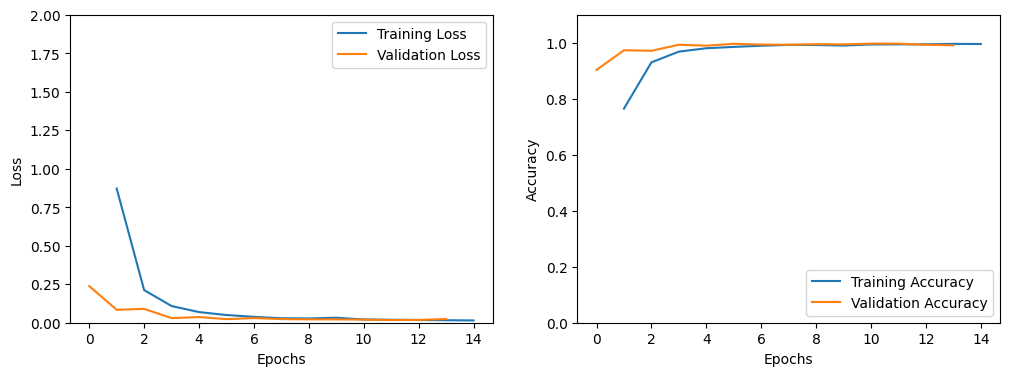

In [101]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [103]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [104]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 11) - Validation Loss: 0.020, Validation Accuracy: 0.997


In [105]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.995
Test Time: 21.32 seconds ---> 0.36 minutes


In [ ]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        97
           1       0.99      0.97      0.98       115
           2       1.00      0.98      0.99        94
           3       0.99      0.99      0.99        99
           4       0.98      1.00      0.99       113
           5       1.00      0.98      0.99        95
           6       1.00      0.92      0.96        91
           7       0.91      1.00      0.95       116
           8       0.99      0.95      0.97        94
           9       0.99      0.99      0.99        92
          10       1.00      0.99      1.00       115
          11       0.99      1.00      0.99        94
          12       0.92      0.99      0.96        97
          13       0.99      0.94      0.96       113
          14       1.00      0.99      0.99        99

    accuracy                           0.98      1524
   macro avg       0.98      0.98      0.98      1524
wei